# Wikipedia Page Sizes
- Report out page character counts from wiki markup in XML dumps
- Character counts use pre-rendered, pre-transcluded text, but relative page sizes should serve our study well
- populate `page_lengths_w_date` table
- report page sizes for W and WP:M for both dump dates

In [1]:
# basic defaults, including study dates, common SQL exclusions and parquet files for anonymized data
%run -i 'data-defaults.py'

In [2]:
WIKIPEDIA_XML_DUMPS = ['enwiki-20190401-pages-articles-multistream.xml.bz2',
                       'enwiki-20190420-pages-articles-multistream.xml.bz2']

def page_length(entity, date):
    page_text = entity.revision.text._VALUE
    size = len(page_text)
    return Row(page_id=entity.id, page_length=size, dt=date)

page_lengths_rdd = sc.emptyRDD()
for file in WIKIPEDIA_XML_DUMPS:
    wikipedia = sqlContext.read.format('com.databricks.spark.xml').options(rowTag='page').load(file)
    dump_date = re.search(r'.*(\d{8}).*',file).group(1)
    articles = wikipedia\
        .filter("ns = '0'")\
        .filter("redirect._title is null") \
        .filter("revision.text._VALUE is not null") \
        .filter("length(revision.text._VALUE) > 0")
    daily_page_lengths = sqlContext.createDataFrame(articles.rdd.map(lambda entity: page_length(entity, dump_date)))
    page_lengths_rdd = page_lengths_rdd.union(daily_page_lengths.rdd)

page_lengths_merged = sqlContext.createDataFrame(page_lengths_rdd)

In [4]:
# save page lengths data to a table for later use
page_lengths_merged.registerTempTable("page_lengths_w_date")

## Number of Wikipedia pages
- limited to namespace 0
- excludes redirect pages
- excludes pages without content

In [5]:
# page count of all pages in Wikipedia namespace 0, excluding redirect pages and pages with no content
count_query = """
SELECT dt, count(*) as pages
FROM 
    page_lengths_w_date
GROUP BY dt
"""
counts = spark.sql(count_query)
counts.show()

+--------+-------+
|      dt|  pages|
+--------+-------+
|20190420|5847824|
|20190401|5839083|
+--------+-------+



## Sizes of W pages with external links

In [6]:
# page_lengths of W pages w/ ext links
w_pl_query = """
SELECT dt, CAST(AVG(page_length) AS DECIMAL(10,2)) AS average_page_length, 
    PERCENTILE(page_length,0.5) AS median_page_length,
    STDDEV(page_length) as stddev_page_length,
    (PERCENTILE(page_length,0.75) - PERCENTILE(page_length,0.25)) as iqr_page_length
FROM 
    page_lengths_w_date
WHERE page_id IN 
    (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
GROUP BY dt
"""

w_pl_links = spark.sql(w_pl_query)
w_pl_links.show()

+--------+-------------------+------------------+------------------+---------------+
|      dt|average_page_length|median_page_length|stddev_page_length|iqr_page_length|
+--------+-------------------+------------------+------------------+---------------+
|20190420|            7676.41|            3865.0| 13632.44456286243|         5789.0|
|20190401|            7662.35|            3860.0| 13599.18539683949|         5779.0|
+--------+-------------------+------------------+------------------+---------------+



## Sizes of WP:M pages with external links

In [7]:
# page_lengths of WP:M pages w/ ext links
pm_pl_query = """
SELECT dt, CAST(AVG(page_length) AS DECIMAL(10,2)) AS average_page_length, 
    PERCENTILE(page_length,0.5) AS median_page_length,
    STDDEV(page_length) as stddev_page_length,
    (PERCENTILE(page_length,0.75) - PERCENTILE(page_length,0.25)) as iqr_page_length
FROM 
    page_lengths_w_date
WHERE page_id IN 
    (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
GROUP BY dt
"""

pm_pl_links = spark.sql(pm_pl_query)
pm_pl_links.show()


+--------+-------------------+------------------+------------------+---------------+
|      dt|average_page_length|median_page_length|stddev_page_length|iqr_page_length|
+--------+-------------------+------------------+------------------+---------------+
|20190420|           13084.95|            6628.0|19378.442855890593|        11640.0|
|20190401|           13057.77|            6607.0|19351.962904945245|        11611.0|
+--------+-------------------+------------------+------------------+---------------+



-------
## Statistical analysis

Get W page lengths:

In [8]:
# Plots inline
%matplotlib inline

In [9]:
page_lengths_merged.registerTempTable("page_lengths_merged")

# Page length averages for the 2 samples
w_page_length_query = """
SELECT page_id, AVG(page_length) as page_length
FROM 
    page_lengths_merged
WHERE page_id IN 
    (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
GROUP BY page_id
"""

w_pl = spark.sql(w_page_length_query).toPandas()
w_pl.head(3)

,page_id,page_length
0,1677,42747.5
1,1697,24512.0
2,1806,162745.5


Get W:M page lenghts:

In [10]:
page_lengths_merged.registerTempTable("page_lengths_merged")

# Page length averages for the 2 samples
wm_page_length_query = """
SELECT page_id, AVG(page_length) as page_length
FROM 
    page_lengths_merged
WHERE page_id IN 
    (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
GROUP BY page_id
"""

wm_pl = spark.sql(wm_page_length_query).toPandas()
wm_pl.head(3)

,page_id,page_length
0,45645458,3736.0
1,46231410,2911.0
2,22231669,5838.0


### Check distribution

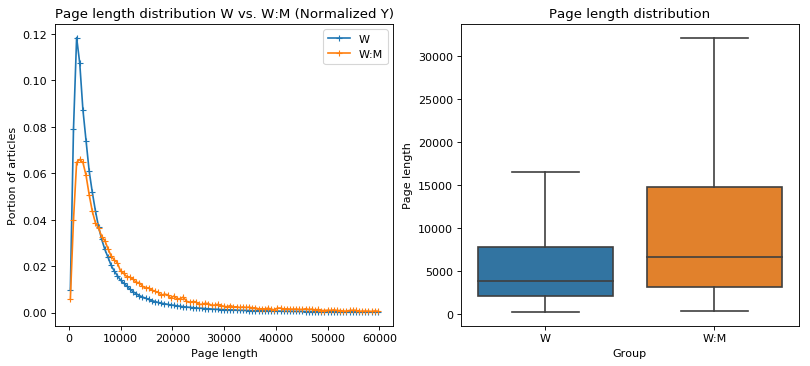

In [11]:
from scipy.stats import binned_statistic


def get_normalized_hist(bins, data):
    total_elements = len(data)
    groups = binned_statistic(data, data, bins = bins, statistic = lambda r: len(r) / total_elements)
    bin_centers = pd.Series(groups.bin_edges).rolling(2, 2).mean().dropna()
    return bin_centers, groups.statistic

bins = np.linspace(0, 60000, 100)
w_distribution = get_normalized_hist(bins, w_pl.page_length)
wm_distribution = get_normalized_hist(bins, wm_pl.page_length)

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)

ax = plt.plot(w_distribution[0], w_distribution[1], marker='+', label="W")
ax = plt.plot(wm_distribution[0], wm_distribution[1], marker='+', label="W:M")

plt.gca().legend(loc="upper right")


plt.title("Page length distribution W vs. W:M (Normalized Y)")
plt.xlabel("Page length")
plt.ylabel("Portion of articles")

plt.subplot(122)

w_pl['Group'] = "W"
wm_pl['Group'] = "W:M"

length_distribution = w_pl.append(wm_pl)
sns.boxplot(x="Group", y="page_length", data=length_distribution, showfliers=False)
plt.ylabel("Page length")
plt.title("Page length distribution")


### Normality test

In [12]:
from scipy import stats

def test_normality(data):  
    k2, p = stats.normaltest(data)
    alpha = 1e-3
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected. p < {:g}".format(alpha))
    else:
        print("The null hypothesis cannot be rejected. p = {:g}".format(p))

print("Normal Test W:M")
test_normality(wm_pl.page_length)

print("\nNormal Test W")
test_normality(w_pl.page_length)

Normal Test W:M
The null hypothesis can be rejected. p < 0.001

Normal Test W
The null hypothesis can be rejected. p < 0.001


### Mann Whitney U Test

https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [13]:
from scipy.stats import mannwhitneyu

# compare samples
stat, p = mannwhitneyu(w_pl.page_length, wm_pl.page_length)
alpha = 0.001
if p < alpha:
    print('Statistics=%.3f, p < %.3f' % (stat, alpha))
else:
    print('Statistics=%.3f, p = %.3f' % (stat, p))
# interpret
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=62209662561.000, p < 0.001
Different distribution (reject H0)


### Validation: Check if the distribution of W:M for the 2 dates is the same

In [14]:
page_lengths_merged.registerTempTable("page_lengths_merged")

# Page length averages for the 2 samples
wm_page_length_query = """
SELECT dt, page_id, page_length
FROM 
    page_lengths_merged
WHERE page_id IN 
    (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
"""

wm_pl_by_date = spark.sql(wm_page_length_query).toPandas()

In [15]:
stat, p = mannwhitneyu(wm_pl_by_date[wm_pl_by_date.dt=='20190420'].page_length, 
                       wm_pl_by_date[wm_pl_by_date.dt=='20190401'].page_length)
alpha = 0.001
if p < alpha:
    print('Statistics=%.3f, p < %.3f' % (stat, alpha))
else:
    print('Statistics=%.3f, p = %.3f' % (stat, p))
# interpret
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=530052889.500, p = 0.384
Same distribution (fail to reject H0)
